In [1]:
import torch
import numpy as np
from transformers import BertTokenizer
from wikipedia2vec import Wikipedia2Vec
import time
import csv
import warnings
import logging

In [2]:
from utils import *
from data_processor import DataProcess

In [3]:
warnings.filterwarnings('ignore')
logging.basicConfig(
        format="%(asctime)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)
logger = logging.getLogger(__name__)

In [4]:
set_seed(42)

In [5]:
# use pretrained bert model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

In [6]:
# use pretrained wiki_vector model
model_file = '/data/suyinpei/wiki_vector.model'
wiki2vec = Wikipedia2Vec.load(model_file)

## Data process

In [7]:
batch_size = 32 # batch size
en_pad_size = 12 # max entity number of one data
en_embd_dim = 100 # entity embedding dim
idf_file = '/data/suyinpei/idf_bigram5.txt'
entity_frep_file = '/data/suyinpei/entity_frep.tsv'
domain_frep_file = '/data/suyinpei/domain_frep.tsv'
data_root = "/data/suyinpei/all_data_1106.tsv" # data: docid, text, entities, label
text_id_root = "/data/suyinpei/text_ids_1028.pt" # data_size * 512
labels_root = "/data/suyinpei/labels_1028.pt" # data_size
entity_id_root = "/data/suyinpei/entity_ids_1028.pt" # data_size * 12
entity_length_root = "/data/suyinpei/entity_length_1028.pt" # data_size
entity_vector_root = "/data/suyinpei/entity_vectors_1028.pt" # en_vocab_size * 100
entity_score_root = "/data/suyinpei/entity_score_1106.pt" # data_size
domain_score_root = "/data/suyinpei/domain_score_1106.pt" # data_size

In [8]:
processor = DataProcess(data_root, text_id_root, labels_root, 
                        entity_id_root, entity_length_root, 
                        entity_score_root, domain_score_root)

In [9]:
# # run this when using new data, build text index and label
# all_input_ids, labels = processor.encode_text(tokenizer)

In [10]:
# # run this when use new data, build entity vector and index
# entity_to_index, index_to_entity = processor.build_entity_vocab()
# idf_dict, unk_idf = processor.load_idf(idf_file)
# build_entity_vector = processor.build_entity_vector(entity_to_index, index_to_entity, 
#                                                     wiki2vec, idf_dict, unk_idf, 
#                                                     en_embd_dim, entity_vector_root)
# all_entity_ids, all_entity_length = processor.build_entity_id(entity_to_index, 
#                                                               index_to_entity, 
#                                                               en_pad_size)

In [11]:
# # run this when use new data, build entity score
# entity_score = processor.build_entity_score(entity_frep_file)

In [12]:
# # run this when use new data, build domain score
# domain_score = processor.build_domain_score(domain_frep_file)

In [13]:
entity_vector = processor.load_entity_vector(entity_vector_root) # get pretrained entity_vector

11/06/2020 07:14:03 - Entity vector shape: torch.Size([1600870, 100])


In [14]:
all_dataloader, train_dataloader, valid_dataloader = processor.load_data(ratio=0.8, batch_size=32) # build train/valid dataloader

11/06/2020 07:14:05 - Num of all_dataloader: 15894
11/06/2020 07:14:05 - Num of train_dataloader: 12715
11/06/2020 07:14:05 - Num of valid_dataloader: 3179


## Model

In [15]:
from model import Model, ModelConfig

In [16]:
mconf = ModelConfig(model_name, entity_vector, en_embd_dim, en_hidden_size1=128, 
                    en_hidden_size2=128, use_en_encoder=True)

In [17]:
bert = Model(mconf)

In [18]:
bert.fix_layer_grad(fix_layer=11)

11/06/2020 07:14:09 - Model : all params: 269.601569M
11/06/2020 07:14:09 - Model : need grad params: 7.710793M


## Start Training

In [18]:
from trainer import Trainer, TrainerConfig

In [19]:
tconf = TrainerConfig(max_epochs=1, learning_rate=6e-4, lr_decay=True, 
                      warmup_tokens=32*200, final_tokens=1*batch_size*len(train_dataloader),
                      num_workers=1, ckpt_path='../models/bert_model.pt')

max_epochs 1
learning_rate 0.0006
lr_decay True
warmup_tokens 6400
final_tokens 406880
num_workers 1
ckpt_path ../models/bert_model.pt


In [20]:
trainer = Trainer(bert, train_dataloader, valid_dataloader, tconf)

11/05/2020 10:04:50 - use device: cuda


In [22]:
# start training
trainer.train()

## Feature generate

In [19]:
from feature_extrator import FeatureExtrator

In [20]:
#load model
bert.load_state_dict(torch.load('../models/bert_model.pt'))

<All keys matched successfully>

In [21]:
feature_extrator = FeatureExtrator(bert, valid_dataloader)

11/06/2020 07:14:13 - use device: cuda


In [22]:
bert_score_root = '/data/suyinpei/bert_score_1106.pt'

In [23]:
# bert_score = feature_extrator.generate_score(bert_score_root)

In [24]:
bert_score, entity_score, domain_score = feature_extrator.get_features(bert_score_root)
data_labels = feature_extrator.get_labels()

In [25]:
class FeatureProcess():
    
    def __init__(self):
        pass
    
    def load_features(self, bert_score, entity_score, domain_score):
        bert_score = bert_score.unsqueeze(-1).to('cpu')
        entity_score = entity_score.unsqueeze(-1)
        domain_score = domain_score.unsqueeze(-1)
        features = torch.cat([bert_score, entity_score],dim=1)
        logger.info("Features shape: {}".format(features.shape))
        return features
    
    def load_labels(self, labels):
        return labels.view(labels.shape[0],-1)

In [26]:
feature_processor = FeatureProcess()

In [27]:
features = feature_processor.load_features(bert_score, entity_score, domain_score)
labels = feature_processor.load_labels(data_labels)

11/06/2020 07:14:19 - Features shape: torch.Size([101716, 2])


## Xgboost Training

In [120]:
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

In [245]:
x_train,x_valid,y_train,y_valid = train_test_split(features.numpy(), labels.numpy(),test_size = 0.2, random_state = 33)

In [246]:
### fit model for train data
model = XGBClassifier(learning_rate=0.1,
                      n_estimators=100,          # 树的个数--1000棵树建立xgboost
                      max_depth=6,               # 树的深度
                      min_child_weight = 1,      # 叶子节点最小权重
                      gamma=0.,                  # 惩罚项中叶子结点个数前的参数
                      subsample=0.8,             # 随机选择80%样本建立决策树
                      objective='binary:logistic', # 指定损失函数
                      scale_pos_weight=1,        # 解决样本个数不平衡的问题
                      random_state=27            # 随机数
                      )

In [247]:
model.fit(x_train,
          y_train,
          eval_set = [(x_valid,y_valid)],
          eval_metric = "logloss",
          early_stopping_rounds = 10,
          verbose = True)

[0]	validation_0-logloss:0.60449
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.53195
[2]	validation_0-logloss:0.47141
[3]	validation_0-logloss:0.42031
[4]	validation_0-logloss:0.37676
[5]	validation_0-logloss:0.33935
[6]	validation_0-logloss:0.30694
[7]	validation_0-logloss:0.27875
[8]	validation_0-logloss:0.25411
[9]	validation_0-logloss:0.23250
[10]	validation_0-logloss:0.21353
[11]	validation_0-logloss:0.19679
[12]	validation_0-logloss:0.18198
[13]	validation_0-logloss:0.16885
[14]	validation_0-logloss:0.15723
[15]	validation_0-logloss:0.14690
[16]	validation_0-logloss:0.13773
[17]	validation_0-logloss:0.12957
[18]	validation_0-logloss:0.12231
[19]	validation_0-logloss:0.11585
[20]	validation_0-logloss:0.11006
[21]	validation_0-logloss:0.10488
[22]	validation_0-logloss:0.10026
[23]	validation_0-logloss:0.09616
[24]	validation_0-logloss:0.09248
[25]	validation_0-logloss:0.08920
[26]	validation_0-logloss:0.08628
[27]	validation_0-loglos

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

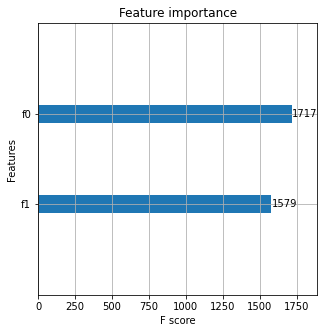

In [248]:
### plot feature importance
fig,ax = plt.subplots(figsize=(5,5))
plot_importance(model,
                height=0.2,
                ax=ax,
                max_num_features=6)
plt.show()

In [249]:
### make prediction for test data
y_pred = np.round(model.predict_proba(x_valid)[:,1])

### model evaluate
accuracy = accuracy_score(y_valid, y_pred)
print("accuarcy: {}".format((accuracy*100.0)))

accuarcy: 97.91093197011404


In [250]:
joblib.dump(model, 'xgboost.model')  #save model

['xgboost.model']

## Test data collection && features generation

In [28]:
from feature_extrator import FeatureExtrator
from test_data_collator import TestDataCollator

In [29]:
entity_to_index, index_to_entity = processor.build_entity_vocab()
idf_dict, unk_idf = processor.load_idf(idf_file)

11/06/2020 07:14:52 - All Entity number: 7744598
11/06/2020 07:15:00 - Entity vocab size: 1600870
11/06/2020 07:15:43 - Load success!


In [30]:
test_batch = 32
test_data_file = "/data/suyinpei/test_data_1k.tsv"

In [31]:
test_data_collator = TestDataCollator(test_data_file)

In [32]:
test_dataloader = test_data_collator.load_data(test_batch, tokenizer, 
                                               entity_to_index, index_to_entity, 
                                               wiki2vec, idf_dict, unk_idf, 
                                               en_pad_size, en_embd_dim, 
                                               entity_frep_file, domain_frep_file)

11/06/2020 07:15:54 - Encode text: Took 10.409568548202515 seconds
11/06/2020 07:15:55 - Entity score vocab size: 667095
11/06/2020 07:15:55 - domain score vocab size: 15942
11/06/2020 07:15:58 - Encode other features: Took 4.572131395339966 seconds


In [33]:
#load model
bert.load_state_dict(torch.load('../models/bert_model.pt'))

<All keys matched successfully>

In [34]:
test_feature_extrator = FeatureExtrator(bert, test_dataloader)

11/06/2020 07:15:59 - use device: cuda


In [35]:
bert_score_test_root = '/data/suyinpei/bert_score_test.pt'

In [36]:
bert_score_test = test_feature_extrator.generate_score(bert_score_test_root, test=True)

Test Progress: 100%|██████████| 32/32 [00:09<00:00,  3.23it/s]
11/06/2020 07:16:09 - Saved success to /data/suyinpei/bert_score_test.pt


In [37]:
bert_score_test, entity_score_test, domain_score_test = test_feature_extrator.get_features(bert_score_test_root)

In [38]:
test_feature_processor = FeatureProcess()

In [39]:
test_features = test_feature_processor.load_features(bert_score_test, entity_score_test, domain_score_test)

11/06/2020 07:16:09 - Features shape: torch.Size([999, 2])


## Get final score

In [40]:
import joblib

In [41]:
model = joblib.load('xgboost.model_0') #load saved model

In [42]:
y_pred = model.predict_proba(test_features.numpy())[:,1]

In [43]:
logger.info('Predict number: {}'.format(y_pred.shape[0]))
for i in range(2):
    f = open(test_data_file)
    fout = open('../data/model_predict.tsv','w')
    reader = csv.reader(f, delimiter='\t')
    for line, prob in zip(reader, y_pred):
        docid = line[0]
        fout.write('{}\t{}\n'.format(docid, prob))         

11/06/2020 08:53:25 - Predict number: 999


In [47]:
y_pred[:10]

array([0.9997, 0.9997, 0.9995, 0.0119, 0.0008, 0.9996, 0.0019, 0.9995,
       0.9975, 0.9996], dtype=float32)

In [45]:
torch.set_printoptions(
    precision=4,    # 精度，保留小数点后几位，默认4
    threshold=100,
    edgeitems=10,
    linewidth=80,  # 每行最多显示的字符数，默认80，超过则换行显示
    profile=None,
    sci_mode=False  # 用科学技术法显示数据，默认True
)

In [46]:
np.set_printoptions(
    precision=4,
    suppress=True
)